In [51]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [52]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla K80'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [0]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [0]:
class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate) 
        # self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

In [58]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

x_mean, x_std = x_train.mean(), x_train.var()**0.5
y_mean, y_std = y_train.mean(), y_train.var()**0.5

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std


num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Homoscedastic_Model_Wrapper(input_dim = 1, output_dim = 1, no_units = 100, learn_rate = 1e-1,
                                      batch_size = batch_size, no_batches = 1, init_log_noise = 0)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i], net.network.log_noise.exp().cpu().data.numpy()))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
            samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss =  164.060, KL loss =  347.107, noise =  1.032
Epoch:   101/ 2000, Fit loss =   46.881, KL loss =  351.645, noise =  0.751
Epoch:   201/ 2000, Fit loss =   25.487, KL loss =  356.399, noise =  0.692
Epoch:   301/ 2000, Fit loss =    5.998, KL loss =  361.035, noise =  0.651
Epoch:   401/ 2000, Fit loss =   -1.786, KL loss =  365.240, noise =  0.598
Epoch:   501/ 2000, Fit loss =   -1.536, KL loss =  369.138, noise =  0.581
Epoch:   601/ 2000, Fit loss =  -26.350, KL loss =  373.013, noise =  0.555
Epoch:   701/ 2000, Fit loss =  -66.080, KL loss =  377.931, noise =  0.491
Epoch:   801/ 2000, Fit loss =  -82.541, KL loss =  384.716, noise =  0.441
Epoch:   901/ 2000, Fit loss = -115.861, KL loss =  390.306, noise =  0.425
Epoch:  1001/ 2000, Fit loss = -103.584, KL loss =  395.729, noise =  0.493
Epoch:  1101/ 2000, Fit loss = -143.469, KL loss =  400.659, noise =  0.396
Epoch:  1201/ 2000, Fit loss = -168.787, KL loss =  405.014, noise =  0.342
Epoch:  1301

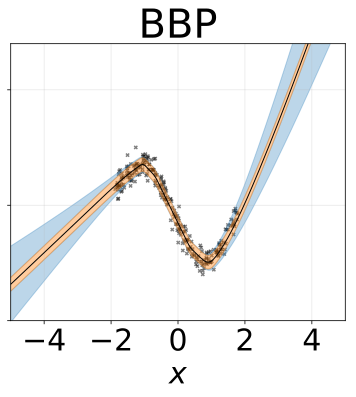

In [59]:
samples = []
for i in range(100):
    preds = (best_net.forward(torch.linspace(-5, 5, 200).cuda())[0] * y_std) + y_mean
    samples.append(preds.cpu().data.numpy()[:, 0])

samples = np.array(samples)
means = samples.mean(axis = 0)

aleatoric = best_net.log_noise.exp().cpu().data.numpy()
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter((x_train * x_std) + x_mean, (y_train * y_std) + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = r'$\sigma(y^*|x^*)$')
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = r'$\EX[\sigma^2]^{1/2}$')
plt.plot(np.linspace(-5, 5, 200)*x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('BBP', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('bbp_homo.pdf', bbox_inches = 'tight')

files.download("bbp_homo.pdf")

plt.show()